# Danish Waters AIS Data Analysis

Analysis of AIS (Automatic Identification System) vessel tracking data from Danish waters.

The dataset contains:
- **Data files**: Actual vessel tracking information (positions, speeds, courses, timestamps)
- **DatasetInfo files**: Metadata about the datasets (regions, time periods, filtering criteria)

In [70]:
"""
Load 
AISVesselTracks/dataset/danish_waters/*.pkl files 
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm

# Configure plot defaults
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [71]:
# Load all pickle files
data_dir = "./dataset/danish_waters"
all_files = glob.glob(os.path.join(data_dir, "*.pkl"))
print(f"Found {len(all_files)} files in {data_dir}")

# Separate data and metadata files
data_files = [f for f in all_files if 'data_AIS' in os.path.basename(f) and not 'datasetInfo' in f]
info_files = [f for f in all_files if 'datasetInfo' in os.path.basename(f)]

print(f"  → {len(data_files)} data files")
print(f"  → {len(info_files)} metadata files")

Found 10 files in ./dataset/danish_waters
  → 5 data files
  → 5 metadata files


In [72]:
# Load and combine all data files into a single DataFrame
dfs = []
for file in tqdm(data_files, desc="Loading data files"):
    data_dict = pd.read_pickle(file)
    dfs.append(pd.DataFrame(data_dict))

# Combine all data
df = pd.concat(dfs, ignore_index=True)
print(f"\nCombined shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Loading data files: 100%|██████████| 5/5 [00:00<00:00, 1249.94it/s]


Combined shape: (402, 8)
Columns: ['mmsi', 'shiptype', 'track_length', 'lat', 'lon', 'speed', 'course', 'timestamp']

First few rows:
   mmsi  shiptype  track_length        lat        lon  speed  course  \
0     0        36             9  55.146145  15.110447    0.0     0.0   
1     0        36             9  55.146145  15.110447    0.0     0.0   
2     0        36             9  55.146142  15.110402    0.0     0.0   
3     0        36             9  55.146142  15.110402    0.0     0.0   
4     0        36             9  55.146142  15.110402    0.0     0.0   

      timestamp  
0  1.626681e+09  
1  1.626682e+09  
2  1.626682e+09  
3  1.626683e+09  
4  1.626683e+09  


In [73]:
# Prepare data for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Combine all data files
all_dfs = []
for filename, data in all_data.items():
    if not filename.startswith('datasetInfo'):
        # Convert dict to DataFrame
        df_temp = pd.DataFrame(data)
        all_dfs.append(df_temp)

# Merge all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)

# Convert timestamp to datetime
combined_df['datetime'] = pd.to_datetime(combined_df['timestamp'], unit='s')

print(f"✓ Combined {len(all_dfs)} data files")
print(f"✓ Total records: {len(combined_df):,}")
print(f"✓ Columns: {list(combined_df.columns)}")

✓ Combined 3 data files
✓ Total records: 361
✓ Columns: ['mmsi', 'shiptype', 'track_length', 'lat', 'lon', 'speed', 'course', 'timestamp', 'datetime']


In [74]:
# 4. Speed by Ship Type
print("="*70)
print("AVERAGE SPEED BY SHIP TYPE")
print("="*70)
speed_by_type = combined_df.groupby('shiptype')['speed'].agg(['mean', 'median', 'min', 'max']).round(2)
speed_by_type = speed_by_type.sort_values('mean', ascending=False)
print(speed_by_type)

AVERAGE SPEED BY SHIP TYPE
          mean  median   min   max
shiptype                          
80        6.64    6.66  6.48  6.70
90        0.44    0.18  0.00  3.26
36        0.00    0.00  0.00  0.00


In [75]:
# 3. Top Vessels
print("="*70)
print("TOP 10 MOST ACTIVE VESSELS")
print("="*70)
top_vessels = combined_df['mmsi'].value_counts().head(10)
for rank, (mmsi, count) in enumerate(top_vessels.items(), 1):
    pct = (count / len(combined_df)) * 100
    print(f"{rank:2d}. MMSI {mmsi}: {count:7,} points ({pct:5.2f}%)")

TOP 10 MOST ACTIVE VESSELS
 1. MMSI 205038000:     297 points (82.27%)
 2. MMSI 0:      45 points (12.47%)
 3. MMSI 205097000:      19 points ( 5.26%)


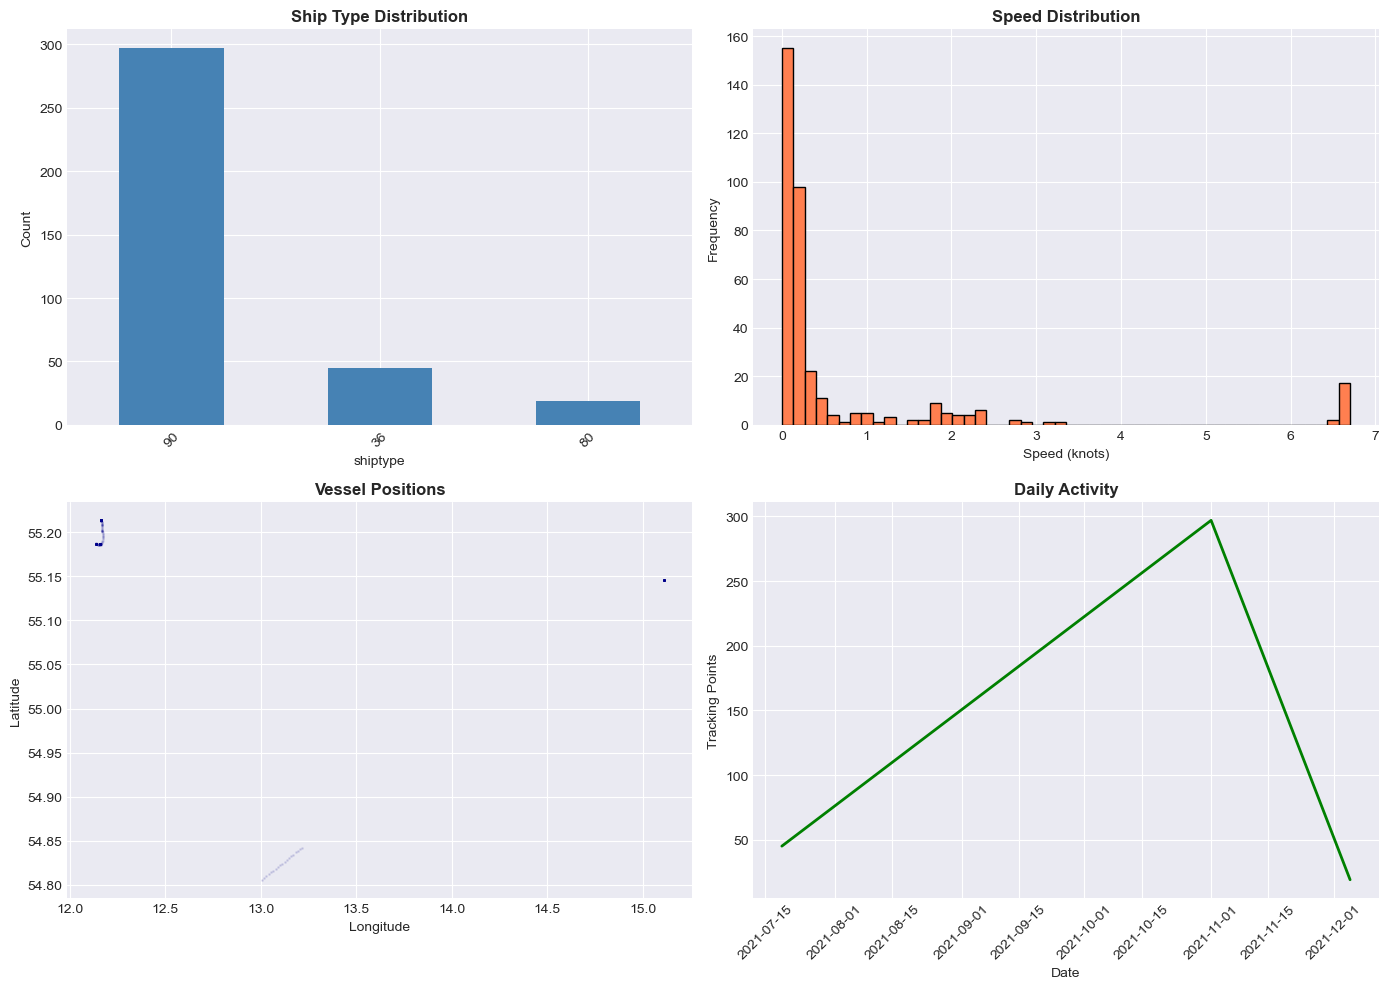

In [76]:
# 2. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ship type distribution
combined_df['shiptype'].value_counts().plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Ship Type Distribution', fontweight='bold')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Speed distribution
axes[0,1].hist(combined_df['speed'], bins=50, color='coral', edgecolor='black')
axes[0,1].set_title('Speed Distribution', fontweight='bold')
axes[0,1].set_xlabel('Speed (knots)')
axes[0,1].set_ylabel('Frequency')

# Geographic scatter
axes[1,0].scatter(combined_df['lon'], combined_df['lat'], alpha=0.1, s=1, c='darkblue')
axes[1,0].set_title('Vessel Positions', fontweight='bold')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

# Daily activity
daily_counts = combined_df.groupby(combined_df['datetime'].dt.date).size()
axes[1,1].plot(daily_counts.index, daily_counts.values, color='green', linewidth=2)
axes[1,1].set_title('Daily Activity', fontweight='bold')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Tracking Points')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [77]:
# 1. Basic Statistics
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"\nShape: {combined_df.shape}")
print(f"Unique vessels (MMSI): {combined_df['mmsi'].nunique():,}")
print(f"Time range: {combined_df['datetime'].min()} to {combined_df['datetime'].max()}")
print(f"Duration: {(combined_df['datetime'].max() - combined_df['datetime'].min()).days} days")

print("\n" + "="*70)
print("SHIP TYPES")
print("="*70)
print(combined_df['shiptype'].value_counts())

print("\n" + "="*70)
print("SPEED STATISTICS (knots)")
print("="*70)
print(combined_df['speed'].describe())

print("\n" + "="*70)
print("GEOGRAPHIC BOUNDS")
print("="*70)
print(f"Latitude:  {combined_df['lat'].min():.4f}° to {combined_df['lat'].max():.4f}°")
print(f"Longitude: {combined_df['lon'].min():.4f}° to {combined_df['lon'].max():.4f}°")

DATASET OVERVIEW

Shape: (361, 9)
Unique vessels (MMSI): 3
Time range: 2021-07-19 07:51:37 to 2021-12-05 12:55:36
Duration: 139 days

SHIP TYPES
shiptype
90    297
36     45
80     19
Name: count, dtype: int64

SPEED STATISTICS (knots)
count    361.000000
mean       0.712619
std        1.536967
min        0.000000
25%        0.000000
50%        0.167194
75%        0.360111
max        6.700638
Name: speed, dtype: float64

GEOGRAPHIC BOUNDS
Latitude:  54.8058° to 55.2134°
Longitude: 12.1355° to 15.1104°


## Metadata Analysis

In [78]:
# Summary of metadata
print("\n" + "="*70)
print("METADATA SUMMARY")
print("="*70)

metadata_files = {k: v for k, v in all_data.items() if k.startswith('datasetInfo')}

for filename, meta in metadata_files.items():
    if isinstance(meta, dict):
        print(f"\n📍 Dataset: {filename}")
        
        # Extract key filtering info
        if 'timeperiod' in meta:
            print(f"   Time Period: {meta['timeperiod']}")
        if 'ROI' in meta:
            print(f"   Region of Interest (ROI): {meta['ROI']}")
        if 'navstatuses' in meta:
            print(f"   Nav Statuses: {meta['navstatuses']}")
        if 'shiptypes' in meta:
            print(f"   Ship Types: {meta['shiptypes']}")
        if 'maxspeed' in meta:
            print(f"   Max Speed Filter: {meta['maxspeed']} knots")
        if 'minTrackLength' in meta and 'maxTrackLength' in meta:
            print(f"   Track Length Range: {meta['minTrackLength']} to {meta['maxTrackLength']}")
        if 'binedges' in meta:
            binedges = meta['binedges']
            if isinstance(binedges, (list, np.ndarray)):
                print(f"   Bin Edges: {binedges}")
        if 'dataFileName' in meta:
            print(f"   Source File: {meta['dataFileName']}")


METADATA SUMMARY

📍 Dataset: datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_3000_43200_600.pkl
   Time Period: (1622498400.0, 1638313199.000999)
   Region of Interest (ROI): (54.5, 56, 13, 16)
   Nav Statuses: [0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 96, 97, 99]
   Ship Types: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 30, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 36, 37, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
   Max Speed Filter: 20 knots
   Track Length Range: 3000 to 43200
   Source File: data/Unlabelled Data/data_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_3000_43200_600.pkl

📍 Dataset: datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl
   Time Period: (1622498400.0, 1638313199.000999)
   Region of Interest (ROI): (54.5, 56, 13, 16)
   Nav Statuses: [0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 96, 97, 99]
   Ship Types: [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 30, 60, 61, 6

In [79]:
# Extract and analyze metadata files
print("="*70)
print("METADATA FILES CONTENT")
print("="*70)

for filename, data in all_data.items():
    if filename.startswith('datasetInfo'):
        print(f"\n {filename}")
        print("-" * 70)
        
        if isinstance(data, dict):
            for key, value in data.items():
                # Truncate long values
                if isinstance(value, (list, np.ndarray)):
                    value_str = f"[{len(value)} items] {str(value)[:100]}..."
                elif isinstance(value, dict):
                    value_str = f"{{keys: {list(value.keys())}}}"
                else:
                    value_str = str(value)[:150]
                
                print(f"  {key:20s}: {value_str}")

METADATA FILES CONTENT

 datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_3000_43200_600.pkl
----------------------------------------------------------------------
  indicies            : [81407 items] [0, 550, 1100, 2100, 2695, 4145, 5730, 7948, 10706, 13464, 16222, 18980, 19983, 20626, 21179, 22947,...
  dataFileName        : data/Unlabelled Data/data_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_3000_43200_600.pkl
  ROI                 : (54.5, 56, 13, 16)
  timeperiod          : (1622498400.0, 1638313199.000999)
  maxspeed            : 20
  navstatuses         : [16 items] [0, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 96, 97, 99]...
  shiptypes           : [44 items] [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 30, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 80, 81, 82, 83,...
  binedges            : (array([54.5 , 54.51, 54.52, 54.53, 54.54, 54.55, 54.56, 54.57, 54.58,
       54.59, 54.6 , 54.61, 54.62, 54.63, 54.64, 54.65, 54.66, 54.67,
       54
  minTrackLength

## Sampling Helper

## Refresh & Size Listing

## Sample Analytics & Visuals

## Optional Full Load (Heavy)

## Check Unique Vessels (Sample)

_Note: Sampling is used to keep memory reasonable. Set `DO_FULL_CONCAT=True` to force a full in-memory load (may not fit for 5GB)._

In [80]:
# Ensure sampled data is available
if 'combined_sample' not in globals():
    print("combined_sample not found — building a fresh sample...")
    columns_keep = ['mmsi', 'shiptype', 'lat', 'lon', 'speed', 'course', 'timestamp']
    def load_sample(file_path, n=200_000, frac=None, random_state=42, columns=None):
        data = pd.read_pickle(file_path)
        df_local = pd.DataFrame(data)
        if columns:
            df_local = df_local[columns]
        if frac is not None:
            df_local = df_local.sample(frac=frac, random_state=random_state)
        elif n is not None and len(df_local) > n:
            df_local = df_local.sample(n=n, random_state=random_state)
        return df_local.reset_index(drop=True)
    sample_dfs = []
    for f in tqdm(data_files, desc="Sampling data files"):
        sample = load_sample(f, n=200_000, random_state=42, columns=columns_keep)
        sample_dfs.append(sample)
    combined_sample = pd.concat(sample_dfs, ignore_index=True)
    combined_sample['datetime'] = pd.to_datetime(combined_sample['timestamp'], unit='s')
    print(f"Sampled shape: {combined_sample.shape}")
    print(f"Sample unique MMSI: {combined_sample['mmsi'].nunique():,}")

combined_sample not found — building a fresh sample...


Sampling data files: 100%|██████████| 5/5 [00:00<00:00, 454.58it/s]

Sampled shape: (402, 8)
Sample unique MMSI: 3


In [81]:
# Quick MMSI check on sample
print(f"Sample unique MMSI: {combined_sample['mmsi'].nunique():,}")
print(combined_sample['mmsi'].value_counts().head(20))

Sample unique MMSI: 3
mmsi
205038000    297
0             86
205097000     19
Name: count, dtype: int64


In [82]:
# Optional: full concat (may be heavy for 5GB). Enable with DO_FULL_CONCAT=True
DO_FULL_CONCAT = False
combined_full = None

if DO_FULL_CONCAT:
    full_dfs = []
    for f in tqdm(data_files, desc="Loading FULL data files"):
        full_dfs.append(pd.DataFrame(pd.read_pickle(f)))
    combined_full = pd.concat(full_dfs, ignore_index=True)
    combined_full['datetime'] = pd.to_datetime(combined_full['timestamp'], unit='s')
    print(f"Full concat shape: {combined_full.shape}")
    print(f"Unique vessels (MMSI): {combined_full['mmsi'].nunique():,}")

SAMPLED DATA OVERVIEW
               mmsi    shiptype         lat         lon       speed  \
count  4.020000e+02  402.000000  402.000000  402.000000  402.000000   
mean   1.611769e+08   77.975124   55.166453   12.834992    0.639939   
min    0.000000e+00   36.000000   54.805800   12.135520    0.000000   
25%    2.050380e+08   80.000000   55.146145   12.159827    0.000000   
50%    2.050380e+08   90.000000   55.186261   12.165349    0.145370   
75%    2.050380e+08   90.000000   55.187859   13.050712    0.295086   
max    2.050970e+08   90.000000   55.213433   15.110447    6.700638   
std    8.418785e+07   22.026268    0.079477    1.205565    1.472198   

           course     timestamp                       datetime  
count  402.000000  4.020000e+02                            402  
mean   202.418956  1.633945e+09  2021-10-11 09:32:45.962686464  
min      0.000000  1.626681e+09            2021-07-19 07:51:37  
25%     73.040624  1.635727e+09            2021-11-01 00:28:38  
50%    220.67

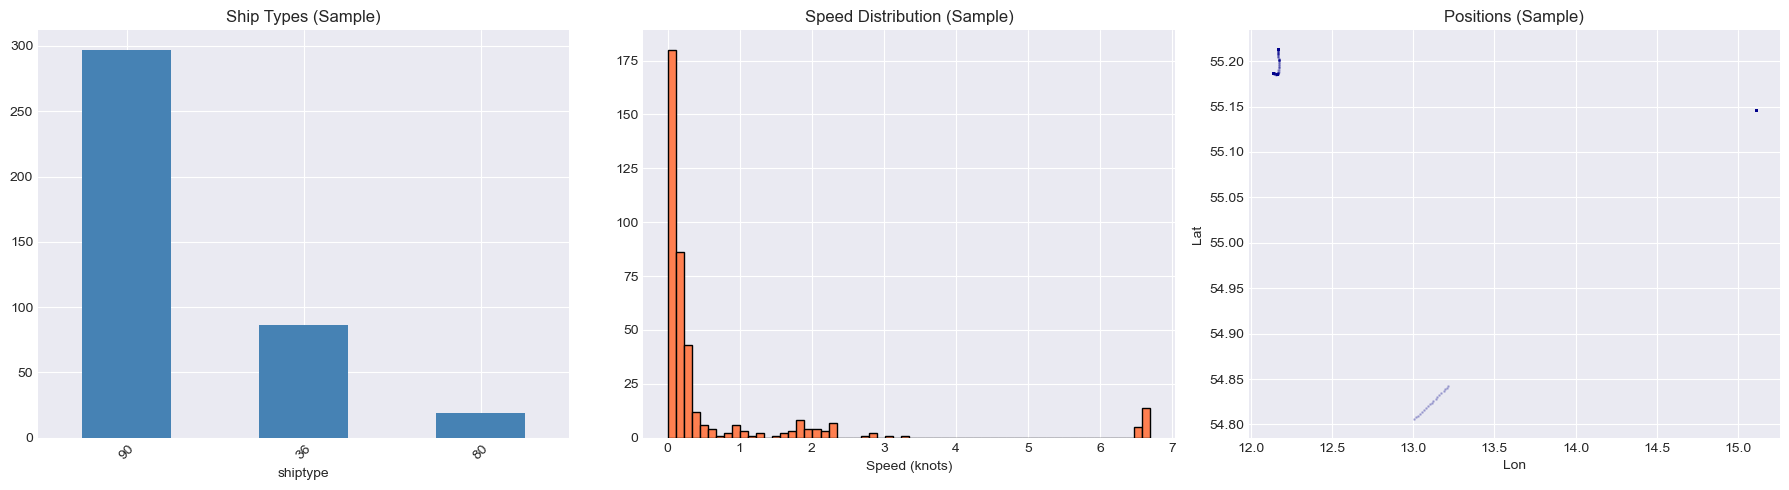

In [83]:
# Quick analytics on sampled data
print("="*70)
print("SAMPLED DATA OVERVIEW")
print("="*70)
print(combined_sample.describe(include='all'))

print("\nShip type counts (sample):")
print(combined_sample['shiptype'].value_counts())

print("\nTop 10 MMSI by points (sample):")
print(combined_sample['mmsi'].value_counts().head(10))

# Visuals on sampled data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
combined_sample['shiptype'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Ship Types (Sample)')
axes[0].tick_params(axis='x', rotation=45)

axes[1].hist(combined_sample['speed'], bins=60, color='coral', edgecolor='black')
axes[1].set_title('Speed Distribution (Sample)')
axes[1].set_xlabel('Speed (knots)')

axes[2].scatter(combined_sample['lon'], combined_sample['lat'], s=1, alpha=0.2, c='darkblue')
axes[2].set_title('Positions (Sample)')
axes[2].set_xlabel('Lon')
axes[2].set_ylabel('Lat')

plt.tight_layout()
plt.show()

In [84]:
# Sampling helper to avoid OOM on very large pickles
def load_sample(file_path, n=200_000, frac=None, random_state=42, columns=None):
    data = pd.read_pickle(file_path)
    df_local = pd.DataFrame(data)
    if columns:
        df_local = df_local[columns]
    if frac is not None:
        df_local = df_local.sample(frac=frac, random_state=random_state)
    elif n is not None and len(df_local) > n:
        df_local = df_local.sample(n=n, random_state=random_state)
    return df_local.reset_index(drop=True)

columns_keep = ['mmsi', 'shiptype', 'lat', 'lon', 'speed', 'course', 'timestamp']

sample_dfs = []
for f in tqdm(data_files, desc="Sampling data files"):
    sample = load_sample(f, n=200_000, random_state=42, columns=columns_keep)
    sample_dfs.append(sample)

combined_sample = pd.concat(sample_dfs, ignore_index=True)
combined_sample['datetime'] = pd.to_datetime(combined_sample['timestamp'], unit='s')

print(f"Sampled shape: {combined_sample.shape}")
print(f"Unique vessels (MMSI): {combined_sample['mmsi'].nunique():,}")

Sampling data files: 100%|██████████| 5/5 [00:00<00:00, 1251.73it/s]

Sampled shape: (402, 8)
Unique vessels (MMSI): 3


In [85]:
# Refresh file list (including large files)
data_dir = "./dataset/danish_waters"
all_files = glob.glob(os.path.join(data_dir, "*.pkl"))
print(f"Total pickle files: {len(all_files)}")

file_sizes = []
for f in all_files:
    try:
        size_mb = os.path.getsize(f) / 1024 / 1024
    except OSError:
        size_mb = float('nan')
    file_sizes.append((os.path.basename(f), size_mb, f))

file_sizes = sorted(file_sizes, key=lambda x: x[1], reverse=True)
for name, mb, _ in file_sizes:
    print(f"{name:80s} {mb:8.1f} MB")

# Refresh data/metadata splits
data_files = [f for _, _, f in file_sizes if 'data_AIS' in os.path.basename(f) and 'datasetInfo' not in os.path.basename(f)]
info_files = [f for _, _, f in file_sizes if 'datasetInfo' in os.path.basename(f)]
print(f"\nData files: {len(data_files)} | Metadata files: {len(info_files)}")

Total pickle files: 10
data_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_600_99999999_0.pkl      5117.8 MB
data_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl        648.2 MB
data_AIS_Custom_01112021_30112021_CarDivFisHigMilOthPasPilPleSaiTan_600_43200_120.pkl    182.8 MB
data_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_3000_43200_600.pkl       136.0 MB
data_AIS_Custom_01122021_31122021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl         94.2 MB
datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_600_99999999_0.pkl      1.3 MB
datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl      1.1 MB
datasetInfo_AIS_Custom_01062021_30112021_CarFisHigMilPasPleSaiTan_3000_43200_600.pkl      0.8 MB
datasetInfo_AIS_Custom_01112021_30112021_CarDivFisHigMilOthPasPilPleSaiTan_600_43200_120.pkl      0.2 MB
datasetInfo_AIS_Custom_01122021_31122021_CarFisHigMilPasPleSaiTan_600_43200_120.pkl      0.1 MB

Data files: 5 |

## Large File Refresh & Sampling